In [1]:
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
import os
import pickle as pkl

import datetime

%matplotlib inline

# # Make reproducible
seed = 0
np.random.seed(seed)

/jet/var/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/jet/var/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/jet/var/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/jet/var/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: P

1.10.0


In [2]:
def report_on_percentiles(y, y_pred, y_std):

    n = len(y.ravel())

    n1 = np.sum(np.abs(y_pred.ravel() - y.ravel()) <= y_std.ravel() * 1)
    n2 = np.sum(np.abs(y_pred.ravel() - y.ravel()) <= y_std.ravel() * 2)
    n3 = np.sum(np.abs(y_pred.ravel() - y.ravel()) <= y_std.ravel() * 3)
    print('Using {} data points'.format(n))
    print('{} within 1 std'.format(100 * n1 / n))
    print('{} within 2 std'.format(100 * n2 / n))
    print('{} within 3 std'.format(100 * n3 / n))

    return

Create observations

In [3]:
# Create fake dimensions (lat, lon, months, time)
n_years = 20
lats = np.arange(-90, 90, 180/48)
lons = np.arange(-180,180, 360/96)
# Change time so the in sample runs -1, 1
time = np.arange(-1,1, (2/12)/n_years) * 2 + 1
months = np.tile(np.arange(-1,1,2/12), n_years)

# Create smooth function to serve as the observational truth
def fun(time, lat, lon, month):
    f = (0.5 * (((lat/90)  ** 2) + 0.5 * np.sin(2 * np.pi * lon/180)) - 0.2 * np.cos(np.pi * month))
    return f

obs = np.zeros([len(time), len(lats), len(lons)])
for i, t in enumerate(time):
    for j, lat in enumerate(lats):
        for k, lon in enumerate(lons):
            obs[i, j, k] = fun(t, lat, lon, months[i])
            
# Normalise obs
obs = 2 * (obs - obs.min())/(obs.max() - obs.min()) - 1

In [4]:
# Format data so it is suitable for NN input
data_len = obs.size
lon_data = np.tile(lons, int(data_len / len(lons))).reshape(-1,)
lat_data = np.tile(np.repeat(lats, len(lons)), len(time)).reshape(-1,)
time_data = np.repeat(time, int(data_len / len(time))).reshape(-1,)
mon_data = np.repeat(months, int(data_len / len(time))).reshape(-1,)

# model 1  True in the north with a -0.03 bias
mdl1 = obs.copy() - 0.03 + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl1[:,:-16, :] = np.random.random([len(time), len(lats) - 16, len(lons)]) * 2 - 1

# model 2 True around equator with no bias
mdl2 = obs.copy() + np.random.normal(size=[len(time),len(lats), len(lons)]) * 0.005 
mdl2[:,:16, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1
mdl2[:,-16:, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1

# model 3 True around equator with no bias (as per model 2)
mdl3 = obs.copy() + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl3[:,:16, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1
mdl3[:,-16:, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1

# model 4 True in the south with 0.03 bias. True only for months 1-6
mdl4 = obs.copy() + 0.03 + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl4[:,16:, :] = np.random.random([len(time), len(lats) - 16, len(lons)]) * 2 - 1

# Add noise
# In the north we have 0.01 noise
obs[:,-16:, :] = obs[:,-16:, :] + np.random.normal(size=obs[:,-16:, :].shape) * 0.01
# Around the equator we have 0.02 noise
obs[:,16:-16, :] = obs[:,16:-16, :] + np.random.normal(size=obs[:,16:-16, :].shape) * 0.02
# In the south we have 0.03 noise
obs[:,:16, :] = obs[:,:16, :] + np.random.normal(size=obs[:,:16, :].shape) * 0.03

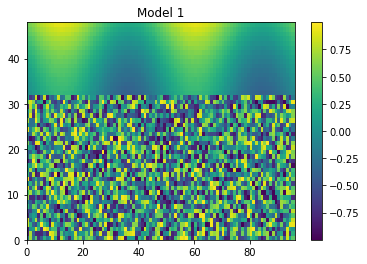

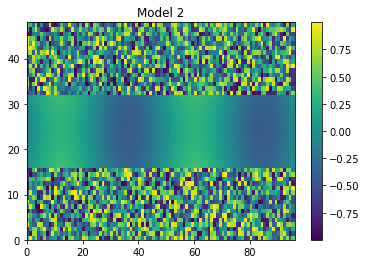

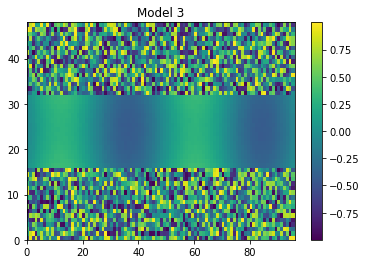

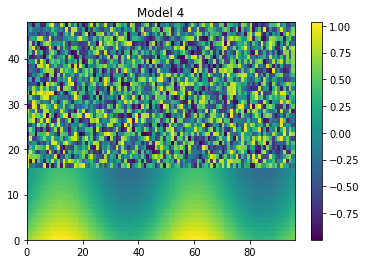

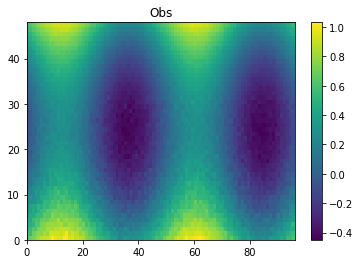

In [5]:
plt.figure()
plt.pcolormesh(mdl1[0])
plt.title('Model 1')
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(mdl2[0])
plt.title('Model 2')
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(mdl3[0])
plt.title('Model 3')
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(mdl4[0])
plt.title('Model 4')
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(obs[0])
plt.title('Obs')
plt.colorbar()
plt.show()

In [6]:
df = pd.DataFrame()
df['mdl1'] = mdl1.ravel()
df['mdl2'] = mdl2.ravel()
df['mdl3'] = mdl3.ravel()
df['mdl4'] = mdl4.ravel()

# Convert the coordinates to have a 1:1 mapping
x = np.cos(lat_data * np.pi / 180)  * np.cos(lon_data * np.pi / 180)
y = np.cos(lat_data * np.pi / 180)  * np.sin(lon_data * np.pi / 180)
z = np.sin(lat_data * np.pi / 180)

rads = (mon_data * 360) * (np.pi / 180)
x_mon = np.sin(rads)
y_mon = np.cos(rads)

# Coordinate scaling
df['x'] = x * 2
df['y'] = y * 2
df['z'] = z * 2
df['x_mon'] = x_mon
df['y_mon'] = y_mon
df['time'] = time_data

df['obs'] = obs.ravel()

# Remove last 10 years to see extrapolation
df_in = df[:int(10 * len(df)/20)]
df_out = df[int(10 * len(df)/20):]

df_shuffled = df_in.sample(frac=1, random_state=seed)
split_idx = round(len(df_shuffled) * 0.85)
df_train = df_shuffled[:split_idx]
df_test = df_shuffled[split_idx:]

# In sample training
X_train = df_train.drop(['obs'],axis=1).values
y_train = df_train['obs'].values.reshape(-1,1)

# The in sample testing - this is not used for training
X_test = df_test.drop(['obs'],axis=1).values
y_test = df_test['obs'].values.reshape(-1,1)

# For out of sample extraploation
X_out = df_out.drop(['obs'],axis=1).values
y_out = df_out['obs'].values.reshape(-1,1)

In [ ]:
# NN set up
tf.reset_default_graph()

num_models = 4

bias_std = 0.01

# prior on the noise 
noise_mean = 0.02
noise_std = 0.004

# hyperparameters
n = X_train.shape[0]
print('Number of data points: {}'.format(n))
x_dim = X_train.shape[1]
alpha_dim = x_dim - num_models
print('Number of input nodes: {}'.format(alpha_dim))
y_dim = y_train.shape[1]
print('Number of output nodes: {}'.format(y_dim))

n_ensembles = 50
hidden_size = 100 #tune
init_stddev_1_w =  np.sqrt(3/(x_dim - num_models))
init_stddev_1_b = init_stddev_1_w
init_stddev_2_w =  1.3/np.sqrt(hidden_size)
init_stddev_2_b = init_stddev_2_w
init_stddev_3_w = (bias_std * 1.3)/np.sqrt(hidden_size)
# Factor to account for 1st layer std being below 1
init_stddev_noise_w = (noise_std * 1.3)/np.sqrt(hidden_size)

lambda_anchor = 1.0/(np.array([init_stddev_1_w,init_stddev_1_b,init_stddev_2_w,init_stddev_2_b,init_stddev_3_w,init_stddev_noise_w])**2)

n_epochs = 6000
batch_size = 2000
learning_rate = 0.00005


# NN class
class NN():
    def __init__(self, x_dim, y_dim, hidden_size, init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w, init_stddev_noise_w, learning_rate, model_bias_from_layer):
        # setting up as for a usual NN
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # set up NN
        self.inputs = tf.placeholder(tf.float32, [None, x_dim], name='inputs')
        self.modelpred = self.inputs[:, :num_models]
        self.spacetime = self.inputs[:, num_models: num_models + alpha_dim]
        self.y_target = tf.placeholder(tf.float32, [None, y_dim], name='target')
        self.layer_1_w = tf.layers.Dense(hidden_size, activation=tf.nn.tanh,
                                         kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_1_w),
                                         bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_1_b))
        self.layer_1 = self.layer_1_w.apply(self.spacetime)
        self.layer_2_w = tf.layers.Dense(num_models, activation=None,
                                         kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_2_w),
                                         bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_2_b))
        self.layer_2 = self.layer_2_w.apply(self.layer_1)

        self.model_coeff = tf.nn.softmax(self.layer_2)

        self.modelbias_w = tf.layers.Dense(self.y_dim, activation=None, use_bias=False,
                                        kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_3_w))
        self.modelbias = self.modelbias_w.apply(self.layer_1)
            
        self.output = tf.reduce_sum(self.model_coeff * self.modelpred, axis=1) + tf.reshape(self.modelbias, [-1])
        
        self.noise_w = tf.layers.Dense(self.y_dim, activation=None, use_bias=False,
                                       kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_noise_w))
        self.noise_pred = self.noise_w.apply(self.layer_1)

        # set up loss and optimiser - we'll modify this later with anchoring regularisation
        self.opt_method = tf.train.AdamOptimizer(self.learning_rate)
        
        self.noise_sq = tf.square(self.noise_pred + noise_mean)[:,0] + 1e-6
        self.err_sq = tf.reshape(tf.square(self.y_target[:,0] - self.output), [-1])
        num_data_inv = tf.cast(tf.divide(1, tf.shape(self.inputs)[0]), dtype=tf.float32)

        self.mse_ = num_data_inv * tf.reduce_sum(self.err_sq)#
        self.loss_ = num_data_inv * (tf.reduce_sum(tf.divide(self.err_sq, self.noise_sq)) + tf.reduce_sum(tf.log(self.noise_sq))) 
        self.optimizer = self.opt_method.minimize(self.loss_)

        return


    def get_weights(self, sess):
        '''method to return current params'''
        ops = [self.layer_1_w.kernel, self.layer_1_w.bias, self.layer_2_w.kernel, self.layer_2_w.bias, self.modelbias_w.kernel, self.noise_w.kernel]
        w1, b1, w2, b2, w3, wn = sess.run(ops)
        return w1, b1, w2, b2, w3, wn

    def anchor(self, sess, lambda_anchor):
        '''regularise around initialised parameters'''
        w1, b1, w2, b2, w3, wn = self.get_weights(sess)

        # get initial params
        self.w1_init, self.b1_init, self.w2_init, self.b2_init, self.w3_init, self.wn_init = w1, b1, w2, b2, w3, wn
        loss_anchor = lambda_anchor[0]*tf.reduce_sum(tf.square(self.w1_init - self.layer_1_w.kernel))
        loss_anchor += lambda_anchor[1]*tf.reduce_sum(tf.square(self.b1_init - self.layer_1_w.bias))
        loss_anchor += lambda_anchor[2]*tf.reduce_sum(tf.square(self.w2_init - self.layer_2_w.kernel))
        loss_anchor += lambda_anchor[3]*tf.reduce_sum(tf.square(self.b2_init - self.layer_2_w.bias))
        loss_anchor += lambda_anchor[4]*tf.reduce_sum(tf.square(self.w3_init - self.modelbias_w.kernel))
        loss_anchor += lambda_anchor[5]*tf.reduce_sum(tf.square(self.wn_init - self.noise_w.kernel)) # new param

        self.loss_anchor = tf.cast(1.0/X_train.shape[0], dtype=tf.float32) * loss_anchor
        
        # combine with original loss
        self.loss_ = self.loss_ + tf.cast(1.0/X_train.shape[0], dtype=tf.float32) * loss_anchor
        self.optimizer = self.opt_method.minimize(self.loss_)
        return

    def predict(self, x, sess):
        '''predict method'''
        feed = {self.inputs: x}
        y_pred = sess.run(self.output, feed_dict=feed)
        return y_pred


    def get_noise_sq(self, x, sess):
        '''get noise squared method'''
        feed = {self.inputs: x}
        noise_sq = sess.run(self.noise_sq, feed_dict=feed)
        return noise_sq
    
    def get_alphas(self, x, sess):
        feed = {self.inputs: x}
        alpha = sess.run(self.model_coeff, feed_dict=feed)
        return alpha
    
    def get_betas(self, x, sess):
        feed = {self.inputs: x}
        beta = sess.run(self.modelbias, feed_dict=feed)
        return beta

    def get_alpha_w(self, x, sess):
        feed = {self.inputs: x}
        alpha_w = sess.run(self.layer_2, feed_dict=feed)
        return alpha_w

    def get_w1(self, x, sess):
        feed = {self.inputs: x}
        w1 = sess.run(self.layer_1, feed_dict=feed)
        return w1

def fn_predict_ensemble(NNs,X_train):
    y_pred=[]
    y_pred_noise_sq=[]
    for ens in range(0,n_ensembles):
        y_pred.append(NNs[ens].predict(X_train, sess))
        y_pred_noise_sq.append(NNs[ens].get_noise_sq(X_train, sess))
    y_preds_train = np.array(y_pred)
    y_preds_noisesq_train = np.array(y_pred_noise_sq)
    y_preds_mu_train = np.mean(y_preds_train,axis=0)
    y_preds_std_train_epi = np.std(y_preds_train,axis=0)
    y_preds_std_train = np.sqrt(np.mean((y_preds_noisesq_train + np.square(y_preds_train)), axis = 0) - np.square(y_preds_mu_train)) #add predicted aleatoric noise
    return y_preds_train, y_preds_mu_train, y_preds_std_train, y_preds_std_train_epi


def get_alphas(NNs, X_train):
    
    alphas = []
    for ens in range(0,n_ensembles):
        alphas.append(NNs[ens].get_alphas(X_train, sess))
        
    return alphas


def get_betas(NNs, X_train):
    
    betas = []
    for ens in range(0,n_ensembles):
        betas.append(NNs[ens].get_betas(X_train, sess))
        
    return betas

def get_alpha_w(NNs, X_train):
    alpha_w = []
    for ens in range(0,n_ensembles):
        alpha_w.append(NNs[ens].get_alpha_w(X_train, sess))
    return alpha_w

def get_w1(NNs, X_train):
    w1 = []
    for ens in range(0,n_ensembles):
        w1.append(NNs[ens].get_w1(X_train, sess))
    return w1

Initialise the NNs

In [ ]:
NNs=[]

sess = tf.Session()
init_weights = []

# loop to initialise all ensemble members
for ens in range(0,n_ensembles):
    NNs.append(NN(x_dim, y_dim, hidden_size, init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w, init_stddev_noise_w,
                  learning_rate, 1))
    # initialise only unitialized variables - stops overwriting ensembles already created
    global_vars = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
      
    # do regularisation now that we've created initialisations
    NNs[ens].anchor(sess, lambda_anchor)

Check the priors

In [ ]:
X_train_short = X_train[:10000]

y_preds_train, y_preds_mu_train, y_preds_std_train, y_preds_std_train_epi = fn_predict_ensemble(NNs,X_train_short)
plt.figure(figsize=(8,8))
plt.errorbar(y_train[:10000], y_preds_mu_train[:10000], yerr=(y_preds_std_train*1)[:10000],linewidth = 0.25, color = 'gray', ms=2,mfc='red',mec='black', fmt='o')
plt.plot(np.arange(np.min(y_train[:10000]), np.max(y_train[:10000]), 0.01), np.arange(np.min(y_train[:10000]), np.max(y_train[:10000]), 0.01), linewidth = 2, linestyle = 'dashed',zorder = 100)
plt.xlabel('True concentration')
plt.ylabel('Predicted concentration')
plt.show()

y_preds_train, y_preds_mu_train, y_preds_std_train, y_preds_std_train_epi = fn_predict_ensemble(NNs,X_train)

### Alphas
alphas = np.array(get_alphas(NNs, X_train_short))
print('Alpha mean should be: {}'.format(1/num_models))
print('Alpha mean is: {}'.format(np.mean(np.array(alphas).ravel())))
print('Alpha std should be: {}'.format(np.sqrt((1/(1 + num_models)) * (1/num_models)*(1-(1/num_models)))))
print('Alpha std is: {}'.format(np.mean(np.std(np.array(alphas), axis=0).ravel())))
report_on_percentiles(alphas, np.array(1/num_models), np.mean(np.std(np.array(alphas), axis=0).ravel()))
print('')

### Beta
beta = np.array(get_betas(NNs, X_train))
print('Beta mean should be: {}'.format(0))
print('Beta mean is: {}'.format(np.mean(beta.ravel())))
print('Beta std should be: {}'.format(bias_std))
print('Beta std is: {}'.format(np.std(beta.ravel())))
report_on_percentiles(beta, np.array(0), np.std(beta.ravel()))
print('')

### Network weights
print('For the layers')
w1 = np.array(get_w1(NNs, X_train_short))
alpha_w = np.array(get_alpha_w(NNs, X_train_short))
print('Layer 1 mean: {}'.format(np.mean(w1.ravel())))
print('Layer 2 mean: {}'.format(np.mean(alpha_w.ravel())))
print('Layer 1 Std: {}'.format(np.mean(np.std(w1, axis=0).ravel())))
print('Layer 2 Std: {}'.format(np.mean(np.std(alpha_w, axis=0).ravel())))
print('')

### Noise
print('For noise')
pred_noise = np.sqrt(np.array([NN.get_noise_sq(X_train, sess) for NN in NNs]))
print('Mean noise is: {}'.format(np.mean(pred_noise)))
print('Mean noise should be: {}'.format(noise_mean))
print('Std noise is: {}'.format(np.std(pred_noise)))
print('Std noise should be: {}'.format(noise_std))

report_on_percentiles(pred_noise, np.array(noise_mean), np.array(noise_std))
print('')

### Untrained output
print('For the predictions')
report_on_percentiles(y_train, y_preds_mu_train, y_preds_std_train)

In [ ]:
l_s = []
m_s = []
a_s = []
# plt.figure(figsize=(6,6))
for ens in range(0,n_ensembles):
    ep_ = 0
    losses = []
    mses = []
    anchs = []
    print('NN:',ens + 1)
    while ep_ < n_epochs:
        ep_ += 1
        
        # Shuffle data every 25 epochs
        if (ep_ % 25) == 0:
            X_train, y_train = shuffle(X_train, y_train, random_state=n_epochs)
            
        for j in range(int(n/batch_size)): #minibatch training loop
            feed_b = {}
            feed_b[NNs[ens].inputs] = X_train[j*batch_size:(j+1)*batch_size, :]
            feed_b[NNs[ens].y_target] = y_train[j*batch_size:(j+1)*batch_size, :]
            blank = sess.run(NNs[ens].optimizer, feed_dict=feed_b)
        if (ep_ % 10) == 0: 
            feed_b = {}
            feed_b[NNs[ens].inputs] = X_train
            feed_b[NNs[ens].y_target] = y_train
            loss_mse = sess.run(NNs[ens].mse_, feed_dict=feed_b)
            loss_anch = sess.run(NNs[ens].loss_, feed_dict=feed_b)
            loss_anch_term = sess.run(NNs[ens].loss_anchor, feed_dict=feed_b)
            losses.append(loss_anch)
            mses.append(loss_mse)
            anchs.append(loss_anch_term)
            print('epoch:' + str(ep_) + ' at ' + str(datetime.datetime.now()))
            print(', rmse_', np.round(np.sqrt(loss_mse),5), ', loss_anch', np.round(loss_anch,5), ', anch_term', np.round(loss_anch_term,5))

    l_s.append(losses)
    m_s.append(mses)
    a_s.append(anchs)

    weight = NNs[ens].get_weights(sess)
    pkl.dump(weight, open('toy_run50shuffled/toy_run6000e_weights{}.pkl'.format(ens), 'wb'))

## Make predictions

In [ ]:
#use trained NN ensemble to generate predictions
y_preds_train, y_preds_mu_train, y_preds_std_train,  y_preds_std_train_epi = fn_predict_ensemble(NNs,X_train)
y_preds_test, y_preds_mu_test, y_preds_std_test,  y_preds_std_test_epi = fn_predict_ensemble(NNs,X_test)
y_preds_out, y_preds_mu_out, y_preds_std_out,  y_preds_std_out_epi = fn_predict_ensemble(NNs,X_out)

In [ ]:
def recube(in_array):

    lat_len = len(lats)
    lon_len = len(lons)
    time_len = len(time)

    output = np.zeros([time_len, lat_len, lon_len])

    for t in range(time_len):
        output[t,:,:] = in_array[lat_len * lon_len * (t): lat_len * lon_len * (t+1)].reshape([lat_len, lon_len])
    
    return output

In [ ]:
betas = np.array(get_betas(NNs, df.drop(['obs'],axis=1).values))
beta = np.mean(betas, axis=(0,2))

In [ ]:
alphas = np.array(get_alphas(NNs, df.drop(['obs'],axis=1).values))
alpha = np.mean(alphas, axis=0)

In [ ]:
pkl.dump(alpha, open('toy_alpha.pkl', 'wb'))

In [ ]:
pkl.dump(beta, open('toy_beta.pkl', 'wb'))

In [ ]:
aletoric_noise = []

for NN in NNs:
    feed_b = {}
    feed_b[NN.inputs] = df.drop(['obs'],axis=1).values
    feed_b[NN.y_target] = df['obs'].values.reshape(-1,1)
    noise_sq = sess.run(NN.noise_sq, feed_dict=feed_b)
    aletoric_noise.append(noise_sq)

In [ ]:
a_n = np.sqrt(recube(np.mean(np.array(aletoric_noise), axis=0)))

In [ ]:
pkl.dump(a_n, open('toy_aleatoric_noise.pkl', 'wb'))

NLL

In [ ]:
print('Train NLL: {}'.format(np.mean(0.5*((((y_preds_mu_train.ravel() - y_train.ravel())**2)/((y_preds_std_train.ravel()**2)) + np.log(y_preds_std_train.ravel()**2) + np.log(2*np.pi))))))
print('Test NLL: {}'.format(np.mean(0.5*((((y_preds_mu_test.ravel() - y_test.ravel())**2)/((y_preds_std_test.ravel()**2)) + np.log(y_preds_std_test.ravel()**2) + np.log(2*np.pi))))))
print('Out of sample NLL: {}'.format(np.mean(0.5*((((y_preds_mu_out.ravel() - y_out.ravel())**2)/((y_preds_std_out.ravel()**2)) + np.log(y_preds_std_out.ravel()**2) + np.log(2*np.pi))))))

RMSE

In [ ]:
print('Train RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_train.ravel() - y_train.ravel())))))
print('Test RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_test.ravel() - y_test.ravel())))))
print('Out of sample RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_out.ravel() - y_out.ravel())))))

Percentils - are the errors appropriate

In [ ]:
print('For training')
report_on_percentiles(y_train, y_preds_mu_train, y_preds_std_train)
print('For testing')
report_on_percentiles(y_test, y_preds_mu_test, y_preds_std_test)
print('For out of sample')
report_on_percentiles(y_out, y_preds_mu_out, y_preds_std_out)